Скачать весь датасет (~5 Гб) можно по этой ссылке: https://drive.google.com/file/d/1CUZnBtYwifVXS21yVg62T-vrPVayso5H/view Файл с отсутствующими скелетами: https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!mkdir -p /content/data
!cp /content/drive/MyDrive/PyTorch/skeleton-data/nturgbd_skeletons_s001_to_s017.zip /content/data/data.zip

In [13]:
!rm -rf /content/data/nturgb+d_skeletons

In [14]:
!unzip -q /content/data/data.zip -d /content/data/

In [15]:
!wget https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt
!cp /content/NTU_RGBD_samples_with_missing_skeletons.txt /content/data/with_missing_skeletons.txt

--2020-12-02 08:56:58--  https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘NTU_RGBD_samples_with_missing_skeletons.txt’

NTU_RGBD_samples_wi     [ <=>                ] 155.09K  --.-KB/s    in 0.02s   

2020-12-02 08:56:58 (6.97 MB/s) - ‘NTU_RGBD_samples_with_missing_skeletons.txt’ saved [158816]



Собрать класс датасет с функциями из ноутбука по генерации датасета. Надо функции перенести в класс + добавить возможность при инициализации менять длину последовательности кадров.

In [118]:
import os

import numpy as np
import pandas as pd

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [119]:
class Croped_Data:
    def __init__(self, data_path, broken_files_path):
        subjects = list(range(0, 28)) #количество людей выполняющих действия
        classes = [8, 10, 22, 23, 27, 21] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
        cameras = [1, 2, 3] 
        max_count = 120  

        labels = []
        counter = 0
        files_counter = {}
        
        self.__files = []
        self.__action_classes = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in classes and camera_id in cameras:  #and subject_id in subjects:
                    
                    if action_class in self.__action_classes:
                        if files_counter[action_class] < max_count:
                            self.__files.append([filename, self.__action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        self.__action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter += 1
                        self.__files.append([filename, self.__action_classes[action_class]])

    def get_files(self):
        return self.__files
    
    
    def get_classes(self):
        return self.__action_classes

In [120]:
data_path = "/content/data/nturgb+d_skeletons/"
broken_files_path = "/content/data/with_missing_skeletons.txt"

data = Croped_Data(data_path, broken_files_path)

In [121]:
# data.get_classes()

In [122]:
# numbers = {v: 0 for k, v in data.get_classes().items()}
# numbers

In [123]:
# len(data.get_files())

In [124]:
# data.get_files()

In [125]:
# a, b = torch.utils.data.random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
# print(a)

In [126]:
class Skeleton_Dataset(Dataset):
    def __init__(self, 
                 inc_data, 
                 data_path, 
                 transform=None, 
                 chonk_len=45):
        
        self.transform = transform
        self.chonk_len = chonk_len
        self.data_path = data_path

        data_lst = []
        labels_lst = []
        numbers = {v: 0 for k, v in inc_data.get_classes().items()}

        for file in inc_data.get_files():
            frames_blocks, label = self.create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data_lst = data_lst + frames_blocks
                labels_lst = labels_lst + label
        
        data_np = np.asarray(data_lst)
        labels_np = np.asarray(labels_lst)

        data_sq = data_np.reshape(len(data_np), -1)
        self.data = pd.DataFrame(data_sq)
        self.data['labels'] = labels_np
        self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.chonk_len, 25*3)
        label = self.labels.values[idx]
        if self.transform != None:
            item = self.transform(item)
        return (item, label)
    
    
    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence


    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]
        return data


    def create_coords_blocks(self, test_file):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = self.chonk_len * int(len(test_frames)/self.chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == self.chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []

        return blocks, new_labels

In [127]:
dataset = Skeleton_Dataset(data, data_path)

In [128]:
dataset.data[:int(0.75*len(dataset.data))].shape

(585, 3376)

In [129]:
label = dataset.labels.values[41]
label

4

In [130]:
skel, lab = dataset.__getitem__(41)

In [131]:
lab

4

In [132]:
skel.shape

(45, 75)

In [133]:
action_classes = [
    "drink water",
    "eat meal/snack",
    "brushing teeth",
    "brushing hair",
    "drop",
    "pickup",
    "throw",
    "sitting down",
    "standing up (from sitting position)",
    "clapping",
    "reading",
    "writing",
    "tear up paper",
    "wear jacket",
    "take off jacket",
    "wear a shoe",
    "take off a shoe",
    "wear on glasses",
    "take off glasses",
    "put on a hat/cap",
    "take off a hat/cap",
    "cheer up",
    "hand waving",
    "kicking something",
    "reach into pocket",
    "hopping (one foot jumping)",
    "jump up",
    "make a phone call/answer phone",
    "playing with phone/tablet",
    "typing on a keyboard",
    "pointing to something with finger",
    "taking a selfie",
    "check time (from watch)",
    "rub two hands together",
    "nod head/bow",
    "shake head",
    "wipe face",
    "salute",
    "put the palms together",
    "cross hands in front (say stop)",
    "sneeze/cough",
    "staggering",
    "falling",
    "touch head (headache)",
    "touch chest (stomachache/heart pain)",
    "touch back (backache)",
    "touch neck (neckache)",
    "nausea or vomiting condition",
    "use a fan (with hand or paper)/feeling warm",
    "punching/slapping other person",
    "kicking other person",
    "pushing other person",
    "pat on back of other person",
    "point finger at the other person",
    "hugging other person",
    "giving something to other person",
    "touch other person's pocket",
    "handshaking",
    "walking towards each other",
    "walking apart from each other",
    "put on headphone",
    "take off headphone",
    "shoot at the basket",
    "bounce ball",
    "tennis bat swing",
    "juggling table tennis balls",
    "hush (quite)",
    "flick hair",
    "thumb up",
    "thumb down",
    "make ok sign",
    "make victory sign",
    "staple book",
    "counting money",
    "cutting nails",
    "cutting paper (using scissors)",
    "snapping fingers",
    "open bottle",
    "sniff (smell)",
    "squat down",
    "toss a coin",
    "fold paper",
    "ball up paper",
    "play magic cube",
    "apply cream on face",
    "apply cream on hand back",
    "put on bag",
    "take off bag",
    "put something into a bag",
    "take something out of a bag",
    "open a box",
    "move heavy objects",
    "shake fist",
    "throw up cap/hat",
    "hands up (both hands)",
    "cross arms",
    "arm circles",
    "arm swings",
    "running on the spot",
    "butt kicks (kick backward)",
    "cross toe touch",
    "side kick",
    "yawn",
    "stretch oneself",
    "blow nose",
    "hit other person with something",
    "wield knife towards other person",
    "knock over other person (hit with body)",
    "grab other person’s stuff",
    "shoot at other person with a gun",
    "step on foot",
    "high-five",
    "cheers and drink",
    "carry something with other person",
    "take a photo of other person",
    "follow other person",
    "whisper in other person’s ear",
    "exchange things with other person",
    "support somebody with hand",
    "finger-guessing game (playing rock-paper-scissors)"
]

# LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}
classes = [8, 10, 22, 23, 27, 21]    
LABELS = {i: action_classes[classes[i]] for i in range(len(classes))}
LABELS

{0: 'standing up (from sitting position)',
 1: 'reading',
 2: 'hand waving',
 3: 'kicking something',
 4: 'make a phone call/answer phone',
 5: 'cheer up'}

In [134]:
# lab

In [135]:
# LABELS[lab]

Задание 2
Построить график зависимости от количества кадров в последовательности (уменьшать и увеличивать)

In [136]:

class LSTM_net(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [137]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [138]:

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [139]:

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

45 кадров

In [140]:

split_train_part = 0.75
train_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(split_train_part*dataset.data.shape[0]), 
                                                             dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [141]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.8267  / kicking something ✗ (standing up (from sitting position))
epoch : 13 iter : 19 (0m 23s) 1.7251  / standing up (from sitting position) ✓
epoch : 27 iter : 1 (0m 37s) 1.4911  / kicking something ✓
epoch : 40 iter : 20 (0m 50s) 1.2850  / standing up (from sitting position) ✗ (reading)
epoch : 54 iter : 2 (1m 4s) 1.2436  / cheer up ✗ (hand waving)
epoch : 67 iter : 21 (1m 17s) 0.9274  / hand waving ✓
epoch : 81 iter : 3 (1m 31s) 0.9211  / standing up (from sitting position) ✗ (hand waving)
epoch : 94 iter : 22 (1m 44s) 1.3827  / make a phone call/answer phone ✗ (cheer up)
epoch : 108 iter : 4 (1m 57s) 1.2438  / standing up (from sitting position) ✓
epoch : 121 iter : 23 (2m 10s) 0.8989  / hand waving ✓
epoch : 135 iter : 5 (2m 24s) 0.5566  / kicking something ✓
epoch : 148 iter : 24 (2m 37s) 0.7512  / standing up (from sitting position) ✓
epoch : 162 iter : 6 (2m 50s) 0.5352  / kicking something ✓
epoch : 175 iter : 25 (3m 3s) 1.0867  / hand waving ✓
ep

35 кадров

In [142]:

# data_path = "/content/data/nturgb+d_skeletons/"
# broken_files_path = "/content/data/with_missing_skeletons.txt"

data = Croped_Data(data_path, broken_files_path)
dataset_c35 = Skeleton_Dataset(data, data_path, chonk_len=35)

In [143]:

dataset_c35.data.shape

(900, 2626)

In [144]:

skel, lab = dataset_c35.__getitem__(41)

In [145]:

skel.shape

(35, 75)

In [146]:

lab

5

In [147]:

split_train_part = 0.75
train_dataset, test_dataset = torch.utils.data.random_split(dataset_c35, 
                                                            [int(split_train_part*dataset_c35.data.shape[0]), 
                                                             dataset_c35.data.shape[0] - int(split_train_part*dataset_c35.data.shape[0])], 
                                                            generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [148]:

n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [149]:

from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(200):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.8010  / kicking something ✗ (hand waving)
epoch : 11 iter : 27 (0m 10s) 1.7685  / make a phone call/answer phone ✗ (standing up (from sitting position))
epoch : 23 iter : 11 (0m 21s) 1.6800  / standing up (from sitting position) ✓
epoch : 34 iter : 38 (0m 32s) 1.4037  / reading ✓
epoch : 46 iter : 22 (0m 43s) 1.1915  / standing up (from sitting position) ✓
epoch : 58 iter : 6 (0m 54s) 1.4001  / standing up (from sitting position) ✓
epoch : 69 iter : 33 (1m 5s) 1.4854  / reading ✗ (hand waving)
epoch : 81 iter : 17 (1m 16s) 1.0420  / make a phone call/answer phone ✓
epoch : 93 iter : 1 (1m 27s) 1.2206  / hand waving ✓
epoch : 104 iter : 28 (1m 38s) 0.9979  / make a phone call/answer phone ✓
epoch : 116 iter : 12 (1m 49s) 1.1937  / kicking something ✗ (reading)
epoch : 127 iter : 39 (2m 0s) 0.8563  / make a phone call/answer phone ✗ (hand waving)
epoch : 139 iter : 23 (2m 11s) 0.7692  / hand waving ✗ (cheer up)
epoch : 151 iter : 7 (2m 21s) 0.5629  / hand wav

Перебор вариантов: 30 - 45 кадров, 1-4 LSTM слоёв

In [150]:
import math

class HyperParSearchDec:
    
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = None
        self.summary_data = pd.DataFrame(data=[[0, 0, 0, 0]], 
                            columns=['layer', 'chonk', 'loss', 'accuracy'])
        self.chonk = np.arange(30, 46, 5)
        self.layer = np.arange(4) + 1
        self.epochs = 200
        self.data_path = "/content/data/nturgb+d_skeletons/"
        broken_files_path = "/content/data/with_missing_skeletons.txt"

        self.data = Croped_Data(self.data_path, broken_files_path)
        self.prev_chonk = 0
        self.train_ld = None

    def net_sample(self, chonk):
        criterion = nn.CrossEntropyLoss()
        learning_rate = 0.0007
        optimizer = optim.SGD(self.net.parameters(), lr=learning_rate, momentum=0.9)

        ep_loss_list = []
        ep_acc_list = []
        start = time.time()
        counter = 0
        
        split_train_part = 0.75
        if self.prev_chonk != chonk:
            dataset = Skeleton_Dataset(self.data, self.data_path, chonk_len=chonk)
            train_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                                        [int(split_train_part*dataset.data.shape[0]), 
                                                                         dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])], 
                                                                        generator=torch.Generator().manual_seed(42))
            self.train_ld = DataLoader(train_dataset, batch_size = 16, shuffle=True)
#             test_ld = DataLoader(test_dataset, batch_size = 1, shuffle=False)
            self.prev_chonk = chonk
        
        for epoch in range(self.epochs):
            loss_list = []
            acc_list = []
            
            for i, data in enumerate(self.train_ld, 0):
                inputs, labels = data[0].to(device), data[1].to(device)

                # обнуляем градиент
                optimizer.zero_grad()

                outputs = self.net(inputs.float())
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                category = LABELS[int(labels[0])]

#                 if counter % 300 == 0:
#                     guess, guess_i = self.categoryFromOutput(output)
#                     correct = '✓' if guess == category else '✗ (%s)' % category
#                     print('\t\t\tepoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, self.timeSince(start), loss, guess, correct))
#                 counter = counter + 1

                # выводим статистику о процессе обучения
                loss_list.append(loss.item())

                # Отслеживание точности
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                acc_list.append(correct / total)
                
            ep_loss_list.append(sum(loss_list) / len(loss_list))
            ep_acc_list.append(sum(acc_list) / len(acc_list))
            counter = counter + 1
            if counter % 100 == 0:
                print(f"\tepoch: {epoch+1}\tloss: {ep_loss_list[-1]:.6f}\taccuracy: {ep_acc_list[-1]*100:.3f}%")
        return ep_loss_list, ep_acc_list
        
    def grid_search(self):
        cnt = 0
        
        path_dir = '/content/drive/MyDrive/PyTorch/HW2/net_lstm'
        if not os.path.exists(path_dir):
            os.mkdir(path_dir)
        
        for n_ch in self.chonk:
            for n_la in self.layer:
                print(f"\nМодель: слоёв lstm: {n_la}, кадров: {n_ch}\n")
                n_hidden = 128
                n_joints = 25*3
                n_categories = len(LABELS)
                self.net = LSTM_net(n_joints, n_hidden, n_categories, n_la).to(self.device)
                # print("\tМодель state_dict: ")
                # for param in self.net.state_dict():
                #     print("\t\t", param,": ", self.net.state_dict()[param].size())
                loss_t, acc_t = self.net_sample(n_ch)
                loss = loss_t[-1]
                acc = acc_t[-1]
                torch.save(self.net.state_dict(), f'/content/drive/MyDrive/PyTorch/HW2/net_lstm/op_net_lstm_{n_la}_chonk_{n_ch}.pth')

                print(f"\tОшибки на train: {loss:.5f}")
                print(f"\tAccuracy на train: {acc:.5f}")
                self.summary_data.loc[cnt, ['layer', 'chonk', 'loss', 'accuracy']] = [n_la, n_ch, loss, acc]
                cnt += 1
                
    def categoryFromOutput(self, output):
        top_n, top_i = output.topk(1)
        category_i = top_i[0].item()
    #     print(output.topk(5))
        return LABELS[category_i], category_i

    def timeSince(self, since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

In [151]:

search_top = HyperParSearchDec()

In [152]:

search_top.grid_search()


Модель: слоёв lstm: 1, кадров: 30

	epoch: 100	loss: 1.022136	accuracy: 61.176%
	epoch: 200	loss: 0.817069	accuracy: 69.719%
	Ошибки на train: 0.81707
	Accuracy на train: 0.69719

Модель: слоёв lstm: 2, кадров: 30

	epoch: 100	loss: 1.114910	accuracy: 55.798%
	epoch: 200	loss: 0.783125	accuracy: 72.109%
	Ошибки на train: 0.78312
	Accuracy на train: 0.72109

Модель: слоёв lstm: 3, кадров: 30

	epoch: 100	loss: 1.408433	accuracy: 40.100%
	epoch: 200	loss: 1.129776	accuracy: 51.906%
	Ошибки на train: 1.12978
	Accuracy на train: 0.51906

Модель: слоёв lstm: 4, кадров: 30

	epoch: 100	loss: 1.790516	accuracy: 18.104%
	epoch: 200	loss: 1.716429	accuracy: 29.910%
	Ошибки на train: 1.71643
	Accuracy на train: 0.29910

Модель: слоёв lstm: 1, кадров: 35

	epoch: 100	loss: 1.012278	accuracy: 63.324%
	epoch: 200	loss: 0.860193	accuracy: 69.331%
	Ошибки на train: 0.86019
	Accuracy на train: 0.69331

Модель: слоёв lstm: 2, кадров: 35

	epoch: 100	loss: 1.061803	accuracy: 60.368%
	epoch: 200	loss: 0

In [153]:

# search_top.summary_data

In [154]:

search_top.summary_data.sort_values('accuracy', ascending=False)

,layer,chonk,loss,accuracy
9,2.0,40.0,0.698743,0.736558
1,2.0,30.0,0.783125,0.721092
5,2.0,35.0,0.717186,0.719477
13,2.0,45.0,0.738314,0.713026
12,1.0,45.0,0.785329,0.707958
0,1.0,30.0,0.817069,0.697190
4,1.0,35.0,0.860193,0.693314
8,1.0,40.0,0.898442,0.661724
10,3.0,40.0,0.992487,0.605322
6,3.0,35.0,1.109383,0.556202


In [161]:

search_top.summary_data.to_csv("/content/drive/MyDrive/PyTorch/HW2/summary_data.csv", index=False)

In [163]:
sum_dat = pd.read_csv("/content/drive/MyDrive/PyTorch/HW2/summary_data.csv")


Построить график зависимости от количества кадров в последовательности (уменьшать и увеличивать)

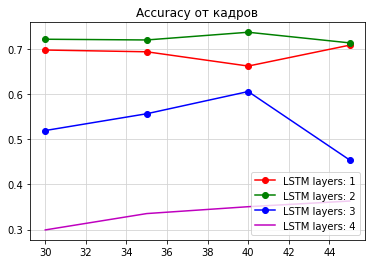

In [182]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 7))

color_list = ['ro-', 'go-', 'bo-', 'm']

for i in range(4):
    # plt.subplot(2, 2, 1)
    plt.plot(np.arange(30, 46, 5),  sum_dat.loc[sum_dat['layer'] == i+1, "accuracy"].values, color_list[i], label="LSTM layers: " + str(i+1))

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('Accuracy от кадров' )
plt.show()

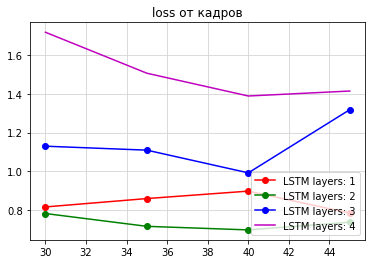

In [183]:
for i in range(4):
    # plt.subplot(2, 2, 2)
    plt.plot(np.arange(30, 46, 5), sum_dat.loc[sum_dat['layer'] == i+1, "loss"].values, color_list[i], label="LSTM layers: " + str(i+1))

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('loss от кадров' )
plt.show()

Задание 3

Построить график зависимости от количества модулей LSTM

In [177]:
chonk_list = np.arange(30, 46, 5)

for i in range(len(chonk_list)):
    print(sum_dat.loc[sum_dat['chonk'] == chonk_list[i], "accuracy"].values)

[0.69718992 0.72109173 0.51905685 0.29909561]
[0.69331395 0.71947674 0.55620155 0.33527132]
[0.66172395 0.73655765 0.60532151 0.35047118]
[0.70795796 0.71302553 0.45382883 0.36298799]


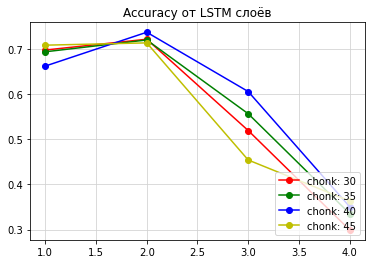

In [184]:
color_list_2 = ['ro-', 'go-', 'bo-', 'yo-', 'm']

for i in range(len(chonk_list)):
    # plt.subplot(2, 2, 3)
    plt.plot(np.arange(4) + 1,  sum_dat.loc[sum_dat['chonk'] == chonk_list[i], "accuracy"].values, color_list_2[i], label="chonk: " + str(chonk_list[i]))

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('Accuracy от LSTM слоёв' )
plt.show()

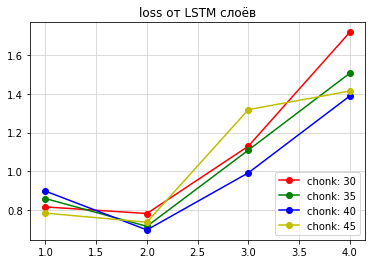

In [185]:
for i in range(len(chonk_list)):
    # plt.subplot(2, 2, 4)
    plt.plot(np.arange(4) + 1,  sum_dat.loc[sum_dat['chonk'] == chonk_list[i], "loss"].values, color_list_2[i], label="chonk: " + str(chonk_list[i]))

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('loss от LSTM слоёв' )
plt.show()